In [1]:
import numpy as np
import numpy.random as npr
from scipy.linalg import solve_discrete_are

In [2]:
np.set_printoptions(precision=3, suppress=True)

In [3]:
hz = 60.0
_sat = 5.0
def f(s, a):
    th, x, thdot, xdot = s
    sdot = np.array([
                thdot, xdot,
                9.81*np.sin(th)/1.0+_sat*a[0]*np.cos(th)/1.0-0.2*thdot,
                _sat*a[0]-0.1*xdot])
    return s + sdot/hz

In [4]:
def wrap2Pi(x):
    th = np.fmod(x+np.pi, 2.0 * np.pi)
    if th < 0:
        th = th + 2.0 * np.pi
    return th - np.pi

Q = np.diag([10., 0.25, 0., 0.001, 0., 0., 0.])
Qf = np.diag([20., 0.2, 0., 0., 0., 0.,0.])
R = np.diag([0.01])

Rinv = np.linalg.inv(R)

def l(x): #loss in z space
    x[0] = wrap2Pi(x[0])
    return np.dot(x, np.dot(Q, x))

def ldx(x):
    x[0] = wrap2Pi(x[0])
    return 2.*np.dot(Q, x)

def m(x): #loss in z space
    x[0] = wrap2Pi(x[0])
    return np.dot(x, np.dot(Qf, x))

def mdx(x):
    x[0] = wrap2Pi(x[0])
    return 2.*np.dot(Qf, x)


In [5]:
state_dim = 4
action_dim = 1

num_x_obs = 7
num_u_obs = 2
num_obs = num_x_obs + num_u_obs

def z(s):
    th, x, thdot, xdot = s
    return np.array([th, x, thdot, xdot, np.sin(th), np.cos(th), 1.])

def v(s, a):
    th, x, thdot, xdot = s
    return np.array([a[0], np.cos(th) * a[0]])

def dvdu(s, a):
    return np.array([[1.0, np.cos(s[0])]]).T
    

In [6]:
npr.seed(0) ## set the seed for reproducibility 
num_trials = 60 ## number of resets
horizon    = 100 ## how long we simulate the system for
M = num_trials * horizon ## M sized data

_A = np.zeros((num_obs, num_obs))
_G = np.zeros((num_obs, num_obs))
cnt = 0
s_bnds = np.array([6.24, 1.0, 2.0, 2.0])
a_bnds = np.array([1.])
## loop to collect data
for k in range(num_trials):
#     x_t = npr.uniform(low=-s_bnds, high=s_bnds)
    x_t = npr.normal(s_bnds*0., s_bnds)
    for t in range(horizon):
        u_t = npr.normal(0.*a_bnds, a_bnds)
        x_tpo = f(x_t, u_t)
        u_tpo = u_t

        z1 = np.concatenate([z(x_t), v(x_t, u_t)])
        z2 = np.concatenate([z(x_tpo), v(x_tpo, u_t)])
        cnt += 1
        _A += np.outer(z2, z1)/cnt
        _G += np.outer(z1, z1)/cnt
        
        # reset for next loop
        x_t = x_tpo
        u_t = u_tpo

        
# _A /= M
# _G /= M

K = np.dot(_A, np.linalg.pinv(_G, hermitian=True))
A = K[:num_x_obs,:num_x_obs]
B = K[:num_x_obs, num_x_obs:]

# A[np.abs(A)<1e-3] = 0
# B[np.abs(B)<1e-3] = 0

/home/burn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/burn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/home/burn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in add
/home/burn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in add


LinAlgError: Eigenvalues did not converge

In [ ]:
T = int(1.5*hz)
u = [np.zeros(1) for t in range(T)]
def update(x, u, A, B):
    zt = z(x.copy())
    zot = []
    for t in range(T):
        zt = z(zt[:state_dim])
        zot.append(zt.copy())
        zt = np.dot(A, zt) + np.dot(B, v(zt[:state_dim], u[t]))
    rho = np.zeros_like(zt)
    for t in reversed(range(T)):
        rho = ldx(zot[t].copy()) + np.dot(A.T, rho)
        Beff = np.dot(B, dvdu(zot[t], u[t]))
#         u[t] = np.clip(-Rinv.dot(Beff.T.dot(rho)), -1., 1.)
        du = Beff.T.dot(rho) + 2.0 * R.dot(u[t])
        u[t] = np.clip(u[t] - 0.1 * du, -1, 1)
    return u

In [8]:
xt = np.array([3.14, 0., 0., 0.])
trajectory = []

for t in range(int(50*hz)):
    u[:-1] = u[1:]
    u[-1] = np.zeros_like(u[-1])
    u = update(xt, u, A, B)

    u1 = u[0]
    xtpo = f(xt, u1)

    z1 = np.concatenate([z(xt), v(xt, u1)])
    z2 = np.concatenate([z(xtpo), v(xtpo, u1)])
    cnt +=1 
    _A += np.outer(z2, z1)/cnt
    _G += np.outer(z1, z1)/cnt
    
    K = np.dot(_A, np.linalg.pinv(_G, hermitian=True))
    A = K[:num_x_obs,:num_x_obs]
    B = K[:num_x_obs, num_x_obs:]
    
    xt = xtpo
    
    trajectory.append(xt.copy())
    if t % 50 == 0:
        print(xt)

[ 3.14   0.     0.084 -0.083]
[ 3.824 -1.418 -1.183 -1.544]
[ 1.538 -1.015 -0.899  1.898]
[ 3.955 -1.054  5.488 -2.092]
[ 5.962 -2.106  0.453 -0.42 ]
[ 6.139 -1.832  0.123  0.985]
[ 6.197 -0.68   0.063  1.758]
[6.274 0.979 0.221 2.237]
[6.392 2.591 0.066 1.454]
[6.407 3.345 0.017 0.374]
[ 6.38   3.216  0.059 -0.501]
[ 6.348  2.449  0.004 -1.164]
[ 6.329  1.303  0.08  -1.425]
[ 6.302 -0.075 -0.068 -1.774]
[ 6.198 -1.528 -0.225 -1.628]
[ 6.19  -2.317  0.062 -0.414]
[ 6.201 -2.393  0.11   0.361]
[ 6.162 -1.925 -0.023  1.022]
[ 6.212 -0.682  0.176  1.946]
[6.313 0.988 0.241 2.113]
[6.39  2.347 0.166 1.269]
[ 6.441  2.831  0.044 -0.069]
[ 6.429  2.18  -0.121 -1.535]
[ 6.339  0.575 -0.107 -2.208]
[ 6.216 -1.298 -0.075 -1.981]
[ 6.19  -2.591 -0.053 -1.145]
[ 6.18  -3.153 -0.052 -0.266]
[ 6.194 -2.988 -0.07   0.486]
[ 6.22  -2.248  0.054  1.182]
[ 6.231 -1.158 -0.039  1.409]
[ 6.223  0.182 -0.065  1.736]
[6.353 1.842 0.137 1.822]
[ 6.405  2.937 -0.037  0.702]
[ 6.376  3.141 -0.079 -0.22 ]
[ 6.

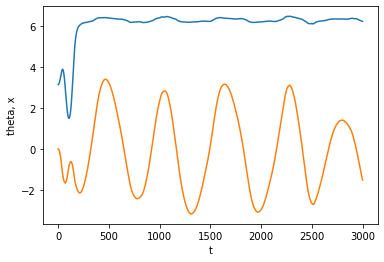

In [9]:
import matplotlib.pyplot as plt
trajectory = np.stack(trajectory)
plt.plot(trajectory[:,0])
plt.plot(trajectory[:,1])
plt.xlabel('t')
plt.ylabel('theta, x')
plt.show()